# Homework Description

- We had trained EfficientNet in our lecture. Your job now is to grab one of the pretraied models from timm library, modify it using inside GetModel function in Section-2. Once you pick your model, you should modify the classification head like we did in the class. You can look up online how other folks modified this piece of the model.



- Then you will train two models. One with freezing all the layers except the classification head you modified. The other is to train the entire model without freezing any layer. 

## Import necessary modules

In [3]:
%matplotlib inline
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
#===========================#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import timm
#============================#
#model interpretibility
from captum.attr import Occlusion
from captum.attr import visualization as viz
#============================#
from tqdm.notebook import tqdm
import shutil
import os
import copy
import random
import sys
from collections import Counter
from torchinfo import summary
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore') 
#===custom functions===========#
sys.path.append('../lectures/')
from utils import create_train_test,get_data_paths,view_samples,view_class_dist
from utils import train_test_model,load_model
from utils import display_predictions,get_confusion_matrix,plot_confusion_matrix,display_all_scores
,GetMisClassifiedImagePaths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 Super


In [4]:
#make your code reproducible to some extent
seed=1234
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [5]:
#there is not train/test in the original data
data_dir = "weather_data/"
create_train_test(data_dir)

train-test split done!
check weather_data/train/ and weather_data/test/


In [ ]:
train_dir = f"{data_dir}/train/"
test_dir = f"{data_dir}/test"
save_dir = "results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Loading the Data via Pytorch DataLoader

In [6]:
#resize the images
width = 224
height = 224

mean = [0.485, 0.456, 0.406]
std =  [0.229, 0.224, 0.225]



training_transforms = transforms.Compose([transforms.Resize((width,height)),
                    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                    transforms.ToTensor(),
                    transforms.Normalize(mean,std)
                ])

test_transforms = transforms.Compose([transforms.Resize((width,height)),
                                      transforms.ToTensor(),
                                     transforms.Normalize(mean,std)
                                     ])



train_set = datasets.ImageFolder(train_dir, transform = training_transforms,)
test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)

#this is what is loaded in each batch
batch_size = 4
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle=True,num_workers=os.cpu_count())
test_loader = DataLoader(test_set,batch_size = batch_size,num_workers=os.cpu_count())

In [7]:
class_list = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx
print(class_to_idx)

idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)
dis_dict = dict(Counter(train_loader.dataset.targets))
class_counts = list(dis_dict.values())

print(class_counts)
print(idx_to_class)

{'cloudy': 0, 'rainy': 1, 'shiny': 2, 'sunrise': 3}
[200, 143, 190, 165]
{0: 'cloudy', 1: 'rainy', 2: 'shiny', 3: 'sunrise'}


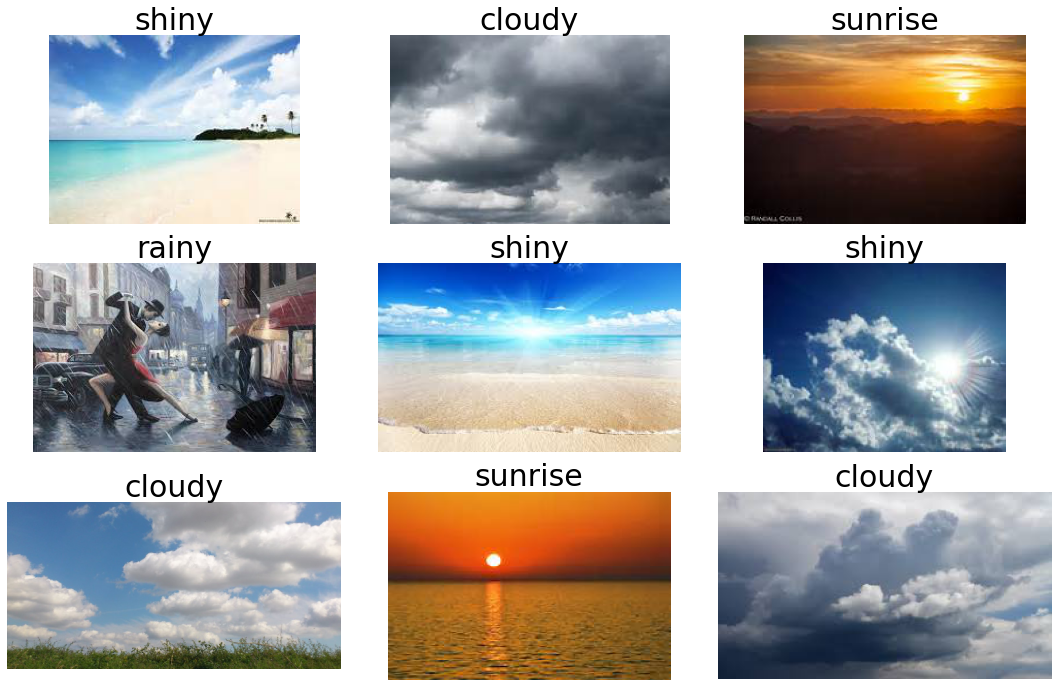

In [8]:
train_image_paths,test_image_paths = GetDataPaths(train_dir, test_dir)
#view some samples
ViewSamples(3,img_paths=train_image_paths)

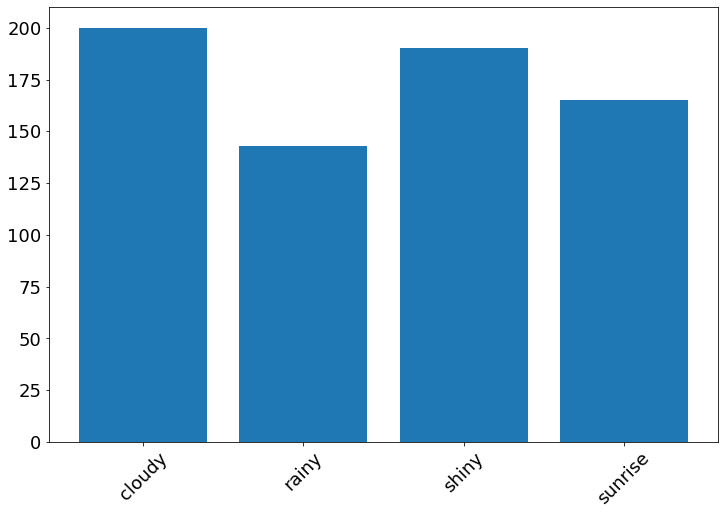

In [9]:
#check the class distribution
ShowClassDist(class_list=class_list,class_counts=class_counts)

# Transfer Learning

- This is the only section you should modify. Decided which pretrained models you will use. To print out all the models avaliable in timm library, run the following cell. After that do some research to pick a good model. If you provide *name_matches_cfg* parameter, you can also filter relevant models. For example name_matches_cfg="resnet" will show you all resnet type models avaliable on timm library.



- After that you need to figure out how to modify your model like we discussed in the class. Carefully modify GetModel function.

In [13]:
timm.list_models(pretrained=True,name_matches_cfg="")

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [ ]:
model = timm.create_model(model_name,',pretrained=True)
print(model)

In [ ]:
model.classifier

In [ ]:
summary(model,input_size=(1,3,width,height))

In [14]:
def GetModel(model_name,freeze = True):
    model = timm.create_model(model_name = model_name,pretrained=True)
    if freeze:
        for parameter in model.parameters():
            parameter.requires_grad = False
    
    
    #modify the classification head here. 
    #in_features = 
    #model.classifier = nn.Sequential()
    
                                    
    return model

In [ ]:
#check number of trainable parameters for freeze version
model_freeze  = GetModel(model_name,freeze=True)
summary(model_freeze,input_size=(1,3,224,224))

In [ ]:
#check number of trainable parameters for no-freeze version
model_full  = GetModel(model_name,freeze=True)
summary(model_full,input_size=(1,3,224,224))

# Training and Testing


In [ ]:
model = DenseModel()
num_epochs = 30
lr = 2e-4
log_int = 5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_name = "best_cnn"
train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int,model_name)


- Train both models. Decide **lr, num_epocs etc.*

In [ ]:
#freeze model
# lr = 1e-2
# num_epochs = 4
# log_int = 10
# StartTraining(model = model_freeze,lr = 1e-4,num_epochs = 30,log_int=5,model_name="freeze")

In [ ]:
#full model
# lr = 1e-2
# num_epochs = 4
# log_int = 10
# StartTraining(model = model_full,lr = 1e-4,num_epochs = 30,log_int=5,model_name="full")

# Post-Processing

First let's load the saved model and use it to evaluate our model performance

In [ ]:
#load model
model = load_model(GetModel(),f"{save_dir}/best.pth")


# Evaluate the Model Performance

## Confusion Matrix

- Plot confusion matrix for both model

In [ ]:
#confusion matrix for dense model.Remember how to use this function 
#cm = get_confusion_matrix()
#plot_confusion_matrix()

## Evaluations Metrics

In [9]:
#Remember how to use this function 
#display_all_scores

**Question** Based on the results in this section, comment on the following questions.

(1) Which model is better an why?











(2) Is there any class your models are struggling to recognize? If so, why could be the reason?











(3) Is there any class that your models is particularly confused with? If so, why could be the reason?











(4) Go back to the cell where we load our data and remove *shuffle=True* option and run the entire notebook. You will see an immidate drop in model accuracy. Do some research to explain why this happens. 











**CONTRIBUTION STATEMENT**

Member-1:



Member-2: